In [0]:
#!pip install -U yellowbrick

In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
%%time
data = pd.read_csv('/content/drive/My Drive/Data/features.csv')
data['Date'] = pd.to_datetime(data['Date'].apply(lambda x: x.split()[0]))

CPU times: user 5.08 s, sys: 436 ms, total: 5.52 s
Wall time: 6.95 s


In [4]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Cardnum_Merchnum,Cardnum_Merch zip,Cardnum_Merch state,Amount_Cardnum_mean_0d,Actual_Amount/Cardnum_mean_0d,Amount_Cardnum_max_0d,Actual_Amount/Cardnum_max_0d,Amount_Cardnum_median_0d,Actual_Amount/Cardnum_median_0d,Amount_Cardnum_sum_0d,Actual_Amount/Cardnum_sum_0d,Cardnum_count_0d,Amount_Cardnum_mean_1d,Actual_Amount/Cardnum_mean_1d,Amount_Cardnum_max_1d,Actual_Amount/Cardnum_max_1d,Amount_Cardnum_median_1d,Actual_Amount/Cardnum_median_1d,Amount_Cardnum_sum_1d,Actual_Amount/Cardnum_sum_1d,Cardnum_count_1d,Amount_Cardnum_mean_3d,Actual_Amount/Cardnum_mean_3d,Amount_Cardnum_max_3d,Actual_Amount/Cardnum_max_3d,Amount_Cardnum_median_3d,Actual_Amount/Cardnum_median_3d,Amount_Cardnum_sum_3d,Actual_Amount/Cardnum_sum_3d,Cardnum_count_3d,Amount_Cardnum_mean_7d,Actual_Amount/Cardnum_mean_7d,Amount_Cardnum_max_7d,Actual_Amount/Cardnum_max_7d,Amount_Cardnum_median_7d,Actual_Amount/Cardnum_median_7d,Amount_Cardnum_sum_7d,Actual_Amount/Cardnum_sum_7d,Cardnum_count_7d,Amount_Cardnum_mean_14d,Actual_Amount/Cardnum_mean_14d,Amount_Cardnum_max_14d,Actual_Amount/Cardnum_max_14d,Amount_Cardnum_median_14d,Actual_Amount/Cardnum_median_14d,Amount_Cardnum_sum_14d,Actual_Amount/Cardnum_sum_14d,Cardnum_count_14d,Amount_Cardnum_mean_30d,Actual_Amount/Cardnum_mean_30d,Amount_Cardnum_max_30d,Actual_Amount/Cardnum_max_30d,Amount_Cardnum_median_30d,Actual_Amount/Cardnum_median_30d,Amount_Cardnum_sum_30d,Actual_Amount/Cardnum_sum_30d,Cardnum_count_30d,Days_since_Cardnum,Amount_Merchnum_mean_0d,Actual_Amount/Merchnum_mean_0d,Amount_Merchnum_max_0d,Actual_Amount/Merchnum_max_0d,Amount_Merchnum_median_0d,Actual_Amount/Merchnum_median_0d,Amount_Merchnum_sum_0d,Actual_Amount/Merchnum_sum_0d,Merchnum_count_0d,Amount_Merchnum_mean_1d,Actual_Amount/Merchnum_mean_1d,Amount_Merchnum_max_1d,Actual_Amount/Merchnum_max_1d,Amount_Merchnum_median_1d,Actual_Amount/Merchnum_median_1d,Amount_Merchnum_sum_1d,Actual_Amount/Merchnum_sum_1d,Merchnum_count_1d,Amount_Merchnum_mean_3d,Actual_Amount/Merchnum_mean_3d,Amount_Merchnum_max_3d,Actual_Amount/Merchnum_max_3d,Amount_Merchnum_median_3d,Actual_Amount/Merchnum_median_3d,Amount_Merchnum_sum_3d,Actual_Amount/Merchnum_sum_3d,Merchnum_count_3d,Amount_Merchnum_mean_7d,Actual_Amount/Merchnum_mean_7d,Amount_Merchnum_max_7d,Actual_Amount/Merchnum_max_7d,Amount_Merchnum_median_7d,Actual_Amount/Merchnum_median_7d,Amount_Merchnum_sum_7d,Actual_Amount/Merchnum_sum_7d,Merchnum_count_7d,Amount_Merchnum_mean_14d,Actual_Amount/Merchnum_mean_14d,Amount_Merchnum_max_14d,Actual_Amount/Merchnum_max_14d,Amount_Merchnum_median_14d,Actual_Amount/Merchnum_median_14d,Amount_Merchnum_sum_14d,Actual_Amount/Merchnum_sum_14d,Merchnum_count_14d,Amount_Merchnum_mean_30d,Actual_Amount/Merchnum_mean_30d,Amount_Merchnum_max_30d,Actual_Amount/Merchnum_max_30d,Amount_Merchnum_median_30d,Actual_Amount/Merchnum_median_30d,Amount_Merchnum_sum_30d,Actual_Amount/Merchnum_sum_30d,Merchnum_count_30d,Days_since_Merchnum,Amount_Cardnum_Merchnum_mean_0d,Actual_Amount/Cardnum_Merchnum_mean_0d,Amount_Cardnum_Merchnum_max_0d,Actual_Amount/Cardnum_Merchnum_max_0d,Amount_Cardnum_Merchnum_median_0d,Actual_Amount/Cardnum_Merchnum_median_0d,Amount_Cardnum_Merchnum_sum_0d,Actual_Amount/Cardnum_Merchnum_sum_0d,Cardnum_Merchnum_count_0d,Amount_Cardnum_Merchnum_mean_1d,Actual_Amount/Cardnum_Merchnum_mean_1d,Amount_Cardnum_Merchnum_max_1d,Actual_Amount/Cardnum_Merchnum_max_1d,Amount_Cardnum_Merchnum_median_1d,Actual_Amount/Cardnum_Merchnum_median_1d,Amount_Cardnum_Merchnum_sum_1d,Actual_Amount/Cardnum_Merchnum_sum_1d,Cardnum_Merchnum_count_1d,Amount_Cardnum_Merchnum_mean_3d,Actual_Amount/Cardnum_Merchnum_mean_3d,Amount_Cardnum_Merchnum_max_3d,Actual_Amount/Cardnum_Merchnum_max_3d,Amount_Cardnum_Merchnum_median_3d,Actual_Amount/Cardnum_Merchnum_median_3d,Amount_Cardnum_Merchnum_sum_3d,Actual_Amount/Cardnum_Merchnum_sum_3d,Cardnum_Merchnum_count_3d,Amount_Cardnum_Merchnum_mean_7d,Actual_Amount

In [5]:
%%time
for key in data.columns:
    if 'Days' in key:
        data[key] = data[key].apply(round)

CPU times: user 384 ms, sys: 94.8 ms, total: 479 ms
Wall time: 488 ms


In [0]:
data = data.drop(columns = ['Recnum', 'Cardnum', 'Merchnum', 'Merch description', 'Merch state', 'Merch zip', 'Transtype',
                            'Cardnum_Merchnum', 'Cardnum_Merch zip', 'Cardnum_Merch state'])

In [7]:
data.head()

,Date,Amount,Fraud,Amount_Cardnum_mean_0d,Actual_Amount/Cardnum_mean_0d,Amount_Cardnum_max_0d,Actual_Amount/Cardnum_max_0d,Amount_Cardnum_median_0d,Actual_Amount/Cardnum_median_0d,Amount_Cardnum_sum_0d,Actual_Amount/Cardnum_sum_0d,Cardnum_count_0d,Amount_Cardnum_mean_1d,Actual_Amount/Cardnum_mean_1d,Amount_Cardnum_max_1d,Actual_Amount/Cardnum_max_1d,Amount_Cardnum_median_1d,Actual_Amount/Cardnum_median_1d,Amount_Cardnum_sum_1d,Actual_Amount/Cardnum_sum_1d,Cardnum_count_1d,Amount_Cardnum_mean_3d,Actual_Amount/Cardnum_mean_3d,Amount_Cardnum_max_3d,Actual_Amount/Cardnum_max_3d,Amount_Cardnum_median_3d,Actual_Amount/Cardnum_median_3d,Amount_Cardnum_sum_3d,Actual_Amount/Cardnum_sum_3d,Cardnum_count_3d,Amount_Cardnum_mean_7d,Actual_Amount/Cardnum_mean_7d,Amount_Cardnum_max_7d,Actual_Amount/Cardnum_max_7d,Amount_Cardnum_median_7d,Actual_Amount/Cardnum_median_7d,Amount_Cardnum_sum_7d,Actual_Amount/Cardnum_sum_7d,Cardnum_count_7d,Amount_Cardnum_mean_14d,Actual_Amount/Cardnum_mean_14d,Amount_Cardnum_max_14d,Actual_Amount/Cardnum_max_14d,Amount_Cardnum_median_14d,Actual_Amount/Cardnum_median_14d,Amount_Cardnum_sum_14d,Actual_Amount/Cardnum_sum_14d,Cardnum_count_14d,Amount_Cardnum_mean_30d,Actual_Amount/Cardnum_mean_30d,Amount_Cardnum_max_30d,Actual_Amount/Cardnum_max_30d,Amount_Cardnum_median_30d,Actual_Amount/Cardnum_median_30d,Amount_Cardnum_sum_30d,Actual_Amount/Cardnum_sum_30d,Cardnum_count_30d,Days_since_Cardnum,Amount_Merchnum_mean_0d,Actual_Amount/Merchnum_mean_0d,Amount_Merchnum_max_0d,Actual_Amount/Merchnum_max_0d,Amount_Merchnum_median_0d,Actual_Amount/Merchnum_median_0d,Amount_Merchnum_sum_0d,Actual_Amount/Merchnum_sum_0d,Merchnum_count_0d,Amount_Merchnum_mean_1d,Actual_Amount/Merchnum_mean_1d,Amount_Merchnum_max_1d,Actual_Amount/Merchnum_max_1d,Amount_Merchnum_median_1d,Actual_Amount/Merchnum_median_1d,Amount_Merchnum_sum_1d,Actual_Amount/Merchnum_sum_1d,Merchnum_count_1d,Amount_Merchnum_mean_3d,Actual_Amount/Merchnum_mean_3d,Amount_Merchnum_max_3d,Actual_Amount/Merchnum_max_3d,Amount_Merchnum_median_3d,Actual_Amount/Merchnum_median_3d,Amount_Merchnum_sum_3d,Actual_Amount/Merchnum_sum_3d,Merchnum_count_3d,Amount_Merchnum_mean_7d,Actual_Amount/Merchnum_mean_7d,Amount_Merchnum_max_7d,Actual_Amount/Merchnum_max_7d,Amount_Merchnum_median_7d,Actual_Amount/Merchnum_median_7d,Amount_Merchnum_sum_7d,Actual_Amount/Merchnum_sum_7d,Merchnum_count_7d,Amount_Merchnum_mean_14d,Actual_Amount/Merchnum_mean_14d,Amount_Merchnum_max_14d,Actual_Amount/Merchnum_max_14d,Amount_Merchnum_median_14d,Actual_Amount/Merchnum_median_14d,Amount_Merchnum_sum_14d,Actual_Amount/Merchnum_sum_14d,Merchnum_count_14d,Amount_Merchnum_mean_30d,Actual_Amount/Merchnum_mean_30d,Amount_Merchnum_max_30d,Actual_Amount/Merchnum_max_30d,Amount_Merchnum_median_30d,Actual_Amount/Merchnum_median_30d,Amount_Merchnum_sum_30d,Actual_Amount/Merchnum_sum_30d,Merchnum_count_30d,Days_since_Merchnum,Amount_Cardnum_Merchnum_mean_0d,Actual_Amount/Cardnum_Merchnum_mean_0d,Amount_Cardnum_Merchnum_max_0d,Actual_Amount/Cardnum_Merchnum_max_0d,Amount_Cardnum_Merchnum_median_0d,Actual_Amount/Cardnum_Merchnum_median_0d,Amount_Cardnum_Merchnum_sum_0d,Actual_Amount/Cardnum_Merchnum_sum_0d,Cardnum_Merchnum_count_0d,Amount_Cardnum_Merchnum_mean_1d,Actual_Amount/Cardnum_Merchnum_mean_1d,Amount_Cardnum_Merchnum_max_1d,Actual_Amount/Cardnum_Merchnum_max_1d,Amount_Cardnum_Merchnum_median_1d,Actual_Amount/Cardnum_Merchnum_median_1d,Amount_Cardnum_Merchnum_sum_1d,Actual_Amount/Cardnum_Merchnum_sum_1d,Cardnum_Merchnum_count_1d,Amount_Cardnum_Merchnum_mean_3d,Actual_Amount/Cardnum_Merchnum_mean_3d,Amount_Cardnum_Merchnum_max_3d,Actual_Amount/Cardnum_Merchnum_max_3d,Amount_Cardnum_Merchnum_median_3d,Actual_Amount/Cardnum_Merchnum_median_3d,Amount_Cardnum_Merchnum_sum_3d,Actual_Amount/Cardnum_Merchnum_sum_3d,Cardnum_Merchnum_count_3d,Amount_Cardnum_Merchnum_mean_7d,Actual_Amount/Cardnum_Merchnum_mean_7d,Amount_Cardnum_Merchnum_max_7d,Actual_Amount/Cardnum_Merchnum_max_7d,Amount_Cardnum_Merchnum_median_7d,

In [0]:
data = data[data['Date'] > pd.to_datetime('2010-01-14')]
train = data[data['Date'] <= pd.to_datetime('2020-10-31')].copy()

In [0]:
X = train.drop(columns=['Fraud', 'Date'])
y = train['Fraud']

In [0]:
rfe = RFE(xgb.XGBRFClassifier(tree_method = 'gpu_hist'), n_features_to_select = 30, step = 1, verbose = 2)

In [11]:
%%time
rfe.fit(X, y)

Fitting estimator with 324 features.
Fitting estimator with 323 features.
Fitting estimator with 322 features.
Fitting estimator with 321 features.
Fitting estimator with 320 features.
Fitting estimator with 319 features.
Fitting estimator with 318 features.
Fitting estimator with 317 features.
Fitting estimator with 316 features.
Fitting estimator with 315 features.
Fitting estimator with 314 features.
Fitting estimator with 313 features.
Fitting estimator with 312 features.
Fitting estimator with 311 features.
Fitting estimator with 310 features.
Fitting estimator with 309 features.
Fitting estimator with 308 features.
Fitting estimator with 307 features.
Fitting estimator with 306 features.
Fitting estimator with 305 features.
Fitting estimator with 304 features.
Fitting estimator with 303 features.
Fitting estimator with 302 features.
Fitting estimator with 301 features.
Fitting estimator with 300 features.
Fitting estimator with 299 features.
Fitting estimator with 298 features.
F

RFE(estimator=XGBRFClassifier(base_score=0.5, colsample_bylevel=1,
                              colsample_bynode=0.8, colsample_bytree=1, gamma=0,
                              learning_rate=1, max_delta_step=0, max_depth=3,
                              min_child_weight=1, missing=None,
                              n_estimators=100, n_jobs=1, nthread=None,
                              objective='binary:logistic', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=None, subsample=0.8,
                              tree_method='gpu_hist', verbosity=1),
    n_features_to_select=30, step=1, verbose=2)

In [0]:
sel = X.columns[rfe.get_support(indices=True)]

In [13]:
len(sel.to_list())

30

In [14]:
sel.to_list()

['Amount_Cardnum_sum_0d',
 'Cardnum_count_0d',
 'Amount_Cardnum_sum_1d',
 'Amount_Merchnum_mean_0d',
 'Amount_Merchnum_max_0d',
 'Amount_Merchnum_sum_0d',
 'Amount_Merchnum_max_1d',
 'Amount_Cardnum_Merchnum_max_0d',
 'Amount_Cardnum_Merch zip_sum_0d',
 'Amount_Cardnum_Merch zip_max_3d',
 'Amount_Cardnum_Merch zip_sum_3d',
 'Cardnum_Merch zip_count_3d',
 'Amount_Cardnum_Merch zip_sum_7d',
 'Cardnum_Merch zip_count_7d',
 'Amount_Cardnum_Merch zip_max_14d',
 'Amount_Cardnum_Merch zip_sum_14d',
 'Cardnum_Merch zip_count_14d',
 'Amount_Cardnum_Merch zip_max_30d',
 'Amount_Cardnum_Merch zip_sum_30d',
 'Amount_Cardnum_Merch state_max_1d',
 'Amount_Cardnum_Merch state_max_3d',
 'Amount_Cardnum_Merch state_sum_3d',
 'Amount_Cardnum_Merch state_max_7d',
 'count_Cardnum_0d/mean_mean_Cardnum_14d',
 'count_Cardnum_0d/mean_mean_Cardnum_30d',
 'count_Cardnum_0d/mean_count_Cardnum_30d',
 'count_Cardnum_1d/mean_mean_Cardnum_30d',
 'count_Cardnum_1d/mean_count_Cardnum_30d',
 'count_Merchnum_0d/mean_cou

In [0]:
X = X[sel]

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


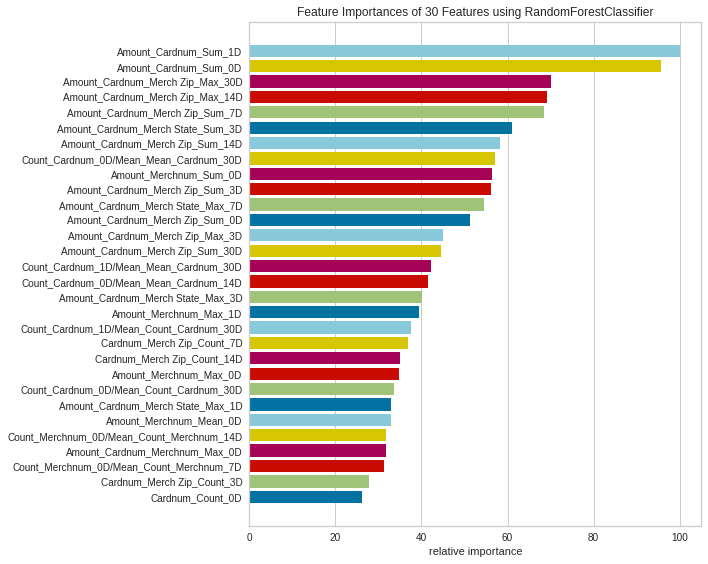

In [19]:
plt.figure(figsize=(10,8))
ax = plt.gca()
labels = list(map(lambda s: s.title(), X.columns))
viz = FeatureImportances(RandomForestClassifier(n_jobs = -1), labels=labels, relative=True)
viz.fit(X, y)
viz.show(ax=ax)